# UFSM
## Engenharia Acústica 
## Processamento Digital de Sinais II
### Trabalho Integrado: rotina de medição

#### Organização dos dados medidos
 
O tipo de dado Struct, do MATLAB, funciona de forma semelhante ao Dictionary do Python. Vamos organizar as variáveis com dicionários dentro de dicionários.

Sugiro que os dados sejam organizados nos seguintes níveis de informação e sequência:
1. Configuração fonte receptor; e.g. S1R1;
2. Sinal de excitação: sweep, música ou fala;
3. Sinal gravado: biauricular, monofônico

É notável que no momento da medição os dados não serão adquiridos nessa sequência. Uma parte do trabalho da nossa rotina de medição é pegar os dados medidos na última tomada e inseri-los no lugar correto do nosso dicionário de medição. Pois a cada tomada o número de posições medidas de receptor  mudará, como já vimos na matriz de teste (e.g. tomada 1 com S1R1 - biauricular, S1R2 - centro da cabeça - e S1R3 - centro do cabeça; tomada 'n' somente com S2R5 - biauricular).

In [2]:
# Carregando as bibliotecas que utilizaremos
import pytta
from scipy.io import wavfile as wf
import copy as cp
import numpy as np
import ipywidgets as widgets

measurementData = {} # Cria o dicionário vazio que conterá todos os níveis de informação do nosso dia de medição

### Carregando dados já medidos

### Salvando dados medidos

### Configuração da medição

In [6]:
# Configuração da medição

# device = [0,1] # Seleciona dispositivo listado em pytta.list_devices()
device = 4 # Seleciona dispositivo listado em pytta.list_devices()
samplingRate = 44100 # [Hz]
freqMin = 20 # [Hz]
freqMax = 20000 # [Hz]
inChannel = [1,2,3,4] # Canais de entrada
channelName = ['Orelha E','Orelha D','Mic 1','Mic 2'] # Lista com o nome dos canais 
outChannel = [1,2] # Canais de saída
averages = 3 # Número de médias por medição (FALTA IMPLEMENTAR NO PYTTA)

sweep = pytta.generate.sweep(freqMin=20, # Geração do sweep (também pode ser carregado projeto prévio)
                            freqMax=20000,
                            fftDegree=17,
                            startMargin=1,
                            stopMargin=1.5,
                            method='logarithmic',
                            windowing='hann')

# sweep = pytta.generate.sweep()

musica = pytta.read_wav('Piano Over the rainbow Mic2  SHORT.wav') # Carregando sinal de música

fala = pytta.read_wav('Voice Sabine Short.WAV') # Carregando sinal de fala

# Criando objetos de medição

playRec = {'sweep' : pytta.generate.measurement('playrec',
                                                excitation=sweep,
                                                samplingRate=samplingRate,
                                                freqMin=freqMin,
                                                freqMax=freqMax,
                                                device=device,
                                                inChannel=inChannel,
                                                outChannel=outChannel,
                                                comment='sweep'),
           'musica' : pytta.generate.measurement('playrec',
                                                excitation=musica,
                                                samplingRate=samplingRate,
                                                freqMin=freqMin,
                                                freqMax=freqMax,
                                                device=device,
                                                inChannel=inChannel,
                                                outChannel=outChannel,
                                                comment='musica'),
           'fala' : pytta.generate.measurement('playrec',
                                                excitation=fala,
                                                samplingRate=samplingRate,
                                                freqMin=freqMin,
                                                freqMax=freqMax,
                                                device=device,
                                                inChannel=inChannel,
                                                outChannel=outChannel,
                                                comment='musica')}

#### Cria signalObj como se fosse uma tomada da medição

In [7]:
# Load de sinal de áudio qualquer para demonstração do código
dummySignal = pytta.read_wav('Piano Over the rainbow Mic2  SHORT.wav')   

# Cria signalObj de 4 canais como seria numa tomada da medição
merge1 = pytta.merge(dummySignal,dummySignal)
measureTake_fake = pytta.merge(merge1,merge1)
measureTake_fake.sourceReceiver = ['S1R1','S1R1','S1R2','S1R3']
measureTake_fake.comment = 'music'
measureTake_fake.temp = 24.666
measureTake_fake.RH = 69
# measureTake = measureTake_fake

### Nova tomada da medição

#### Opções

In [8]:
# Status do canal: True para ligado e False para desligado
channelStatus = [False, # canal 1
                 False, # canal 2
                 True, # canal 3
                 True] # canal 4

# Configuração fonte receptor
# Obs.: manter itens para canais desativados
sourceReceiver = ['S1R1', # canal 1 (ATENÇÃO: canal 1 e 2 tem a mesma cfg.)
                  'S1R1', # canal 2 (ATENÇÃO: canal 1 e 2 tem a mesma cfg.)
                  'S1R2', # canal 3 
                  'S1R3'] # canal 4

excitation = 'sweep'
# excitation = 'musica'
# excitation = 'fala'



#### Aplicando opções

In [9]:
# Redefinindo variável inChannel
j = 1
inChannel = []
for i in channelStatus:
    if i:
        inChannel.append(j)
    j=j+1
playRec[excitation].inChannel = inChannel

### Rodando medição

max output level (excitation):  -1.9382008959705685 dBFs - ref.: 1 [-]
max input level (recording):  -89.01004791259766 dBFs - ref.: 1 [-]


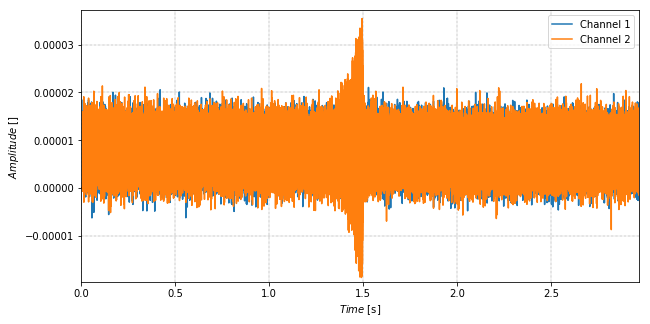

In [10]:
measureTake = playRec[excitation].run()
measureTake.plot_time()
measureTake.temp = 24 # FALTA INTEGRAR LABJACK
measureTake.RH = 69 # FALTA INTEGRAR LABJACK
measureTake.sourceReceiver = sourceReceiver
measureTake.comment = excitation

### Armazenamento da última tomada da medição

#### Prepara última tomada da medição para armazenamento no dicionário de dados medidos

In [11]:
# Desmembra o SignalObj measuretake de 4 canais em 3 SignalObj referentes ao arranjo biauricular 
# em uma posição e ao centro da cabeça em duas outras posições

# BUG AQUI. PRECISA PEGAR O SINAL NO TEMPO DE ACORDO COM STATUS DOS CANAIS

if channelStatus[0] and channelStatus[1]:
    binaural = pytta.SignalObj(measureTake.timeSignal[:,0:2],
                               'time',
                               samplingRate=measureTake.samplingRate,
                               channelName=[measureTake.channelName[0],measureTake.channelName[1]],
                               comment=measureTake.comment)
    binaural.temp = measureTake.temp
    binaural.RH = measureTake.RH
    binaural.sourceReceiver = [measureTake.sourceReceiver[0],measureTake.sourceReceiver[1]]

if channelStatus[2]:
    hc1 = pytta.SignalObj(measureTake.timeSignal[:,2],
                          'time',
                          samplingRate=measureTake.samplingRate,
                          channelName=[measureTake.channelName[2]],
                          comment=measureTake.comment)
    hc1.temp = measureTake.temp
    hc1.RH = measureTake.RH
    hc1.sourceReceiver = measureTake.sourceReceiver[2]

if channelStatus[3]:
    hc2 = pytta.SignalObj(measureTake.timeSignal[:,3],
                          'time',
                          samplingRate=measureTake.samplingRate,
                          channelName=[measureTake.channelName[3]],
                          comment=measureTake.comment)
    hc2.temp = measureTake.temp
    hc2.RH = measureTake.RH
    hc2.sourceReceiver = measureTake.sourceReceiver[3]

# Neste ponto já teríamos tomado uma medição e desmembrado o SignalObj resultante em 3 novos SignalObj, sendo um 
# para o microfone biauricular e dois para os microfones de centro da cabeça.

IndexError: index 2 is out of bounds for axis 1 with size 2

#### Adicionando tomada de medição no dicionário de dados medidos

In [71]:
# Adiciona cada uma das três posições de receptor da última tomada de medição 
if channelStatus[0] and channelStatus[1]:
    measurementData[binaural.sourceReceiver] = {binaural.comment : {'binaural' : binaural }}
elif channelStatus[2]:
    measurementData[hc1.sourceReceiver] = {hc1.comment : {'hc' : hc1 }}
elif channelStatus[3]:
    measurementData[hc2.sourceReceiver] = {hc2.comment : {'hc' : hc2 }}

#### Acessando dados no dicionário de dados medidos

In [72]:
measurementData['S1R1']['sweep']['binaural'].play()

In [74]:
measurementData

{'Channel 1': {'No comments.': {'binaural': <pytta.classes.SignalObj at 0x13496d7b8>}},
 'S1R1': {'sweep': {'binaural': <pytta.classes.SignalObj at 0x134ba6d68>}}}